In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# NOTE: This notebook assignment is currently under construction, and will likely change over time

# Linear regression and learning operators

You've likely encountered linear regression before in the context of fitting lines to data; it represents an interpretable "null hypothesis" model for finding trends in data. However, here we want to think a little more about how to interpret and understand linear regression, and so we will study a different context: learning Markov dynamical models from observations

+ What does ridge penalty do to the system?
+ Nonlinear systems: Picking the right features, and having an invertible feature transform


Two tasks: prediction of RE and regression


## The Navier-Stokes equations

The full Navier-Stokes equations comprise a hyperbolic set of partial differential equations,
$$
\rho\left(\dfrac{\partial \mathbf{u}}{\partial t} + \mathbf{u} \cdot \nabla \mathbf{u}       \right) = -\nabla p + \mu \nabla \cdot \left(    (\nabla \mathbf{u} + (\nabla \mathbf{u})^T) - \dfrac{2}{3} (\nabla \cdot \mathbf{u})\mathbf{I}          \right) + \mathbf{F}
$$
This equation describes several interacting phenomena. The first parenthetical term proportional to the local density $\rho$ corresponds to inertial forces, while the second term corresponds to pressure gradients in the fluid. The term proportional to the viscousity, $\rho$, represents the effect of viscous drag within the fluid, while the forcing term $\mathbf F$ corresponds to external forces.

We usually supplement this partial differential equation with an additional equation describing conservation of momentum,
$$
\dfrac{\partial \rho}{\partial t} + \nabla \cdot (\rho \mathbf{v}) = 0.
$$

Note that the full Navier-Stokes equations describe the dynamical evolution of three coupled fields: the velocity field $\mathbf{u}$, the local density $\rho$, and the pressure $p$. Usually, we will not attempt to directly solve the full equations, but instead we will first reduce these equations to a more specific form based on constraints or symmetries relevant to a specific problem

## The vortex street revisited

We've already seen the von Karman vortex street in a previous homework assignment. 

## To Do

+ In the first part of this homework, you are going to implement a Ridge Regression model yourself and attempt to predict the next values of the Navier-Stokes equations. We then are going to attempt to improve our forecast, first by 


## Additional information

+ There are lots of summaries of the Navier-Stokes equations, their reductions, and the kinds of approximations that people use to numerically solve them. I find the description of the [NS equations in the COMSOL documentation](https://www.comsol.com/multiphysics/navier-stokes-equations) to have some of the most consistent notation and concise exposition that I've found---which is remarkable, given that these are docs for a software package.

Velocity field data has shape: (3000, 256, 128, 2)


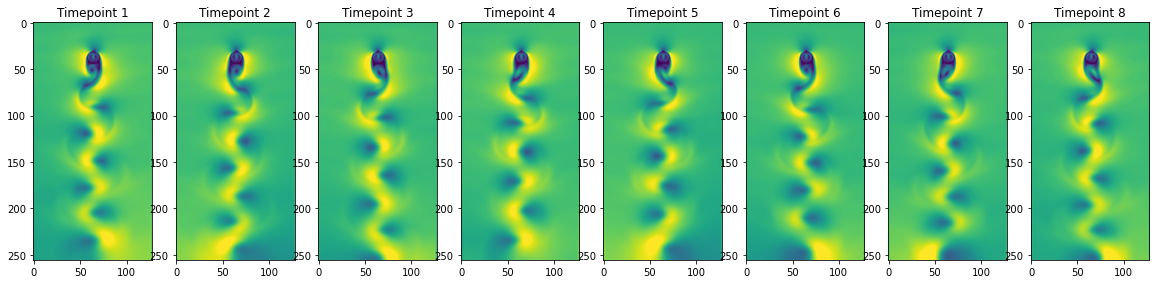

In [11]:

## Load the velocity field data

Re = 300 # Reynolds number, change this to 300, 600, 900, 1200

# Load the two-dimensional velocity field data. Data is stored in a 4D numpy array,
# where the first dimension is the time index, the second and third dimensions are the
# x and y coordinates, and the fourth dimension is the velocity components (ux or uv).
vfield = np.load(
    f"../resources/von_karman_street/vortex_street_velocities_Re_{Re}_largefile.npz", 
    allow_pickle=True
)
print("Velocity field data has shape: {}".format(vfield.shape))

# Compute the velocity magnitude
vfield_mag = np.sqrt(vfield[..., 0]**2 + vfield[..., 1]**2)

n_tpts = vfield.shape[0]
plt.figure(figsize=(20, 10))
for i in range(8):
    plt.subplot(1, 8, i+1)
    v_vals = vfield_mag[n_tpts // 8 * i]
    plt.imshow(v_vals, cmap="viridis", vmin=0, vmax=np.percentile(v_vals, 99))
    plt.title("Timepoint {}".format(i + 1))

In [32]:
## xx homework quesiton about causality?
class ForecastingDataset:
    """
    A class for formatting time series data for forecasting.
    By convention, time is assumed to be the first dimension of the dataset.

    For time series data, it is very important that all data in test set is after 
    all data in the train and val sets. We also need to ensure that datapoints don't
    appear in multiple splits. 
    """

    def __init__(self, X, split_ratio=(0.6, 0.2, 0.2), forecast_horizon=1):

        self.feature_shape = X.shape[1:]

        # We need to ensure that datapoints don't appear in multiple splits, hence why
        # we crop by the forecast horizon. We are going to do one-step forecasting
        self.X_full = X[:-1]#[:-forecast_horizon]
        self.y_full = X[1:]#[forecast_horizon:]
        self.forecast_horizon = forecast_horizon

        # Split the data into train, val, test
        n_train = int(len(self.X_full) * split_ratio[0])
        n_val = int(len(self.X_full) * split_ratio[1])
        n_test = len(self.X_full) - n_train - n_val

        # Our frequent use of the forecast_horizon parameter again arises from our need
        # to ensure that datapoints don't appear in multiple splits.
        self.X_train, self.y_train = self.X_full[:n_train], self.y_full[:n_train]
        self.X_val, self.y_val = (
            self.X_full[n_train + forecast_horizon : n_train + forecast_horizon + n_val], 
            self.y_full[n_train+ forecast_horizon:n_train + forecast_horizon + n_val]
        )
        self.X_test, self.y_test = (
            self.X_full[n_train + 2 * forecast_horizon+ n_val:], 
            self.y_full[n_train + 2 * forecast_horizon + n_val:]
        )

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X_full[idx], self.y_full[idx]

    def flatten_data(self, x):
        """
        Given a dataset, transform into a flat feature form
        """
        return np.reshape(x, (x.shape[0], -1))

    def unflatten_data(self, x):
        """
        Given a flat dataset, convert back to the original shape
        """
        out = np.reshape(x, (x.shape[0], *self.feature_shape))
        return out

# Let's do a simple unit test to make sure that our class is working as expected
# Take some time to understand what these test cases cover

import unittest
class TestForecastingDataset(unittest.TestCase):
    def test_initialization(self):
        fd = ForecastingDataset(np.arange(100)[:, None])
        assert fd.y_train[0] == fd.X_train[1], "y_train is not shifted by 1 from X_train"
        assert fd.y_val[0] == fd.X_val[1], "y_val is not shifted by 1 from X_val"
        assert fd.y_test[0] == fd.X_test[1], "y_test is not shifted by 1 from X_test"
        
        assert fd.y_train[-1] < fd.y_val[0], "y_train and y_test are not disjoint"
        assert fd.y_val[-1] < fd.y_test[0], "y_val and y_test are not disjoint"

unittest.main(argv=[''], exit=False);



.
----------------------------------------------------------------------
Ran 1 test in 0.001s

OK


# Let's restrict our forecasting problem a little bit. We will only use the tail end of the
# wake, where the flow is more turbulent. 



In [ ]:
import numpy as np
import warnings
import matplotlib.pyplot as plt


class BaseRegressor:
    """
    A base class for regression models.
    """
    def __init__(self):
        self.weights = None
        self.bias = None

    def fit(self, X, y):
        """
        Fits the model to the data.
        """
        raise NotImplementedError("Subclasses must implement this method")

    def predict(self, X):
        return X @ self.weights + self.bias

    def score(self, X, y):
        """
        Returns the mean squared error of the model.
        """
        return np.mean((self.predict(X) - y)**2)




class LinearRegressor(BaseRegressor):
    """
    A linear regression model is a linear function of the form:
    y = w0 + w1 * x1 + w2 * x2 + ... + wn * xn

    The weights are the coefficients of the linear function.
    The bias is the constant term w0 of the linear function.

    Attributes:
        method: str, optional. The method to use for fitting the model.
        regularization: str, optional. The type of regularization to use.
    """
    
    def __init__(self, method="global", regularization=None, regstrength=0.0, **kwargs):
        super().__init__(**kwargs)
        self.method = method
        self.regularization = regularization
        self.regstrength = regstrength

    # functions that begin with underscores are private, by convention
    # technically we could access them from outside the class, but we should
    # not do that
    def _fit_global(self, X, y):
        if self.regularization is None:
            self.weights = np.linalg.inv(X.T @ X) @ X.T @ y
        elif self.regularization is "ridge":
            self.weights += np.linalg.inv(X.T @ X + np.eye(X.shape[1]) * self.regstrength) @ X.T @ y
        else:
            warnings.warn("Unknown regularization method, defaulting to None")
            self.weights = np.linalg.inv(X.T @ X) @ X.T @ y
        self.bias = np.mean(y - X @ self.weights)
        return self.weights, self.bias

    def _fit_iterative(self, X, y, learning_rate=0.01):
        self.weights = np.zeros(X.shape[1])
        self.bias = np.mean(y)
        for i in range(X.shape[0]):
            self.weights += learning_rate * (y[i] - X[i] @ self.weights - self.bias) * X[i]
        self.weights /= X.shape[0]
        return self.weights, self.bias

    def fit(self, X, y):
        if self.method == "global":
            out = self._fit_global(X, y)
        elif self.method == "iterative":
            out = self._fit_iterative(X, y)
        else:
            out = self._fit_global(X, y)
        return out






# optional: Lasso and ElasticNet




# class ElasticNetRegressor:

In [ ]:
class FiniteTimeLyapunovExponent:

    def __init__(self, X, y, method="global", regularization=None, regstrength=0.0, **kwargs):
        self.X = X
        self.y = y
        self.method = method
        self.regularization = regularization
        self.regstrength = regstrength

    def fit(self):
        self.model = LinearRegressor(method=self.method, regularization=self.regularization, regstrength=self.regstrength)
        self.model.fit(self.X, self.y)
        self.weights = self.model.weights
        self.bias = self.model.bias
        return self.weights, self.bias

    def predict(self, X):
        return self.model.predict(X)

    def score(self, X, y):
        return self.model.score(X, y)

    def get_finite_time_lyapunov_exponent(self):
        return np.log(np.abs(self.weights)) / self.X.shape[0]

In [ ]:
# Let's look at the structure of the NS equations, to see if we can do something a little bit more sophisticated than just a linear regression.
# The linear regression should cover the first-order

# So We've basically used linear regression to construct 

## Logistic regression and binary classification

Let's now use our vortex street dataset to solve a different supervised learning problem: predicting the Reynolds number of a flow. In this case, we are going to take images of flow fields as inputs, and attempt to predict whether the flow is high-Re (and thus very turbulent) or low-Re (and thus more laminar)

+ Try linear as a baseline
+ Try logistic
+ Featurization: Fourier features


In [1]:
X_all.shape

NameError: name 'X_all' is not defined

In [12]:
X_all.shape

(6000, 256, 128, 2)

In [ ]:
class LogisticRegressor(BaseRegressor):
    """
    A logistic regression model is a linear function of the form:
    y = w0 + w1 * x1 + w2 * x2 + ... + wn * xn

    The weights are the coefficients of the linear function.
    The bias is the constant term w0 of the linear function.

    Attributes:
        method: str, optional. The method to use for fitting the model.
        regularization: str, optional. The type of regularization to use.
    """
    
    def __init__(self, method="global", regularization=None, regstrength=0.0, **kwargs):
        super().__init__(**kwargs)
        self.method = method
        self.regularization = regularization
        self.regstrength = regstrength

    # functions that begin with underscores are private, by convention
    # technically we could access them from outside the class, but we should
    # not do that
    def _fit_global(self, X, y):
        if self.regularization is None:
            self.weights = np.linalg.inv(X.T @ X) @ X.T @ y
        elif self.regularization is "ridge":
            self.weights += np.linalg.inv(X.T @ X + np.eye(X.shape[1]) * self.regstrength) @ X.T @ y
        else:
            warnings.warn("Unknown regularization method, defaulting to None")
            self.weights = np.linalg.inv(X.T @ X) @ X.T @ y
        self.bias = np.mean(y - X @ self.weights)
        return self.weights, self.bias

    def _fit_iterative(self, X, y, learning_rate=0.01):
        self.weights = np.zeros(X.shape[1])
        self.bias = np.mean(y)
        for i in range(X.shape[0]):
            self.weights += learning_rate * (y[i] - X[i] @ self.weights - self.bias) * X[i]
        self.weights /= X.shape[0]
        return self.weights, self.bias

    def fit(self, X, y):
        if self.method == "global":
            out = self._fit_global(X, y)
        elif self.method == "iterative":
            out = self._fit_iterative(X, y)
        else:
            out = self._fit_global(X, y)
        return out

# Predicting the Reynolds number of a turbulent flow

Turbulent flows occur when the partial differential equations governing fluid flows begin to exhibit spatiotemporal chaos. The time-evolution of a viscous, incompressible fluid is given by the celebrated Navier-Stokes equations

$$

$$

The Reynolds number is essentially serves a control parameter that determines a variety of rich behaviors contained within these equations. At low Reynolds numbers, the momentum term essentially goes to zero, and we are left with Stokes' equations, which have weird properties like time reversibility.

High Reynolds numbers are the regime at which turbulence occurs. In this regime, friction appears as a long-timescale damping factor in the dynamics, which are dominated by the hyperbolic, momentum term in the equations.

We won't try to solve the Navier-Stokes equations using machine learning; in the high-Reynolds number regime, that problem is still [a subject of active research](https://www.pnas.org/doi/10.1073/pnas.2101784118). Instead, we will use these equations as a setting for a supervised learning problem: given a snapshot of a flow field, can we predict its Reynolds number






### For fun

This problem is similar to a problem from [Pankaj Mehta's excellent ML course](http://physics.bu.edu/~pankajm/PY580.html), which uses predicting the temperature of the Ising model from snapshots of spins 

In [ ]:


## Make dataset of labelled high and low Reynolds number flows
vfield_lo = np.load(
    f"../resources/von_karman_street/vortex_street_velocities_Re_300_largefile.npz", 
    allow_pickle=True
)

vfield_hi = np.load(
    f"../resources/von_karman_street/vortex_street_velocities_Re_300_largefile.npz", 
    allow_pickle=True
)

X_all = np.vstack((vfield_lo, vfield_hi))
# y_all = np.hstack((np.zeros(vfield_lo.shape[1]), np.ones(vfield_hi.shape[1])))


# n_pts = min(len(vfield_lo, vfield_hi))
# np.random.seed(0)
# idx = np.random.choice(np.arange(n_pts), size=n_pts, replace=False)



# Split train, val, test
# 0.8 train, 0.1 val, 0.1 test



# # Calculate the vorticity, which is the curl of the velocity field
# vort_field = np.diff(vfield, axis=1)[..., :-1, 1] + np.diff(vfield, axis=2)[:, :-1, :, 0] 

In [52]:
xx = np.load(DATA_FOLDER + "kepsilon_CNDV_20580_Cx.npy")
yy = np.load(DATA_FOLDER + "kepsilon_CNDV_20580_Cy.npy")
zz = np.load(DATA_FOLDER + "kepsilon_CNDV_20580_Cz.npy")

vv = np.load(DATA_FOLDER + "kepsilon_CNDV_20580_Ux.npy")

In [47]:
len(vv)

9216

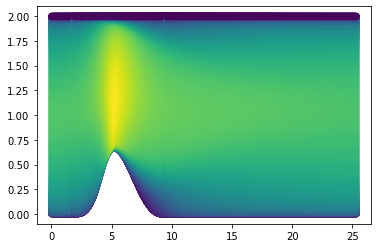

In [53]:
plt.scatter(xx, yy, c=vv)

In [62]:
DATA_FOLDER = "../resources/turbulence/"

# FILENAMES = ["kepsilon_DUCT_3500_p.npy", "kepsilon_DUCT_3500_Ux.npy"]
# FILENAMES = ["kepsilon_DUCT_1100_p.npy", "kepsilon_DUCT_1100_Ux.npy"]
FILENAMES = ["kepsilon_DUCT_2205_p.npy", "kepsilon_DUCT_2205_Ux.npy"]

all_data = np.load(DATA_FOLDER + FILENAMES[0])


xx = np.load(DATA_FOLDER + "kepsilon_DUCT_3500_Cx.npy")
yy = np.load(DATA_FOLDER + "kepsilon_DUCT_3500_Cy.npy")
zz = np.load(DATA_FOLDER + "kepsilon_DUCT_3500_Cz.npy")
vv = np.load(DATA_FOLDER + "kepsilon_DUCT_3500_p.npy")

xx = np.load(DATA_FOLDER + "kepsilonphitf_DUCT_3500_Cx.npy")
yy = np.load(DATA_FOLDER + "kepsilonphitf_DUCT_3500_Cy.npy")
zz = np.load(DATA_FOLDER + "kepsilonphitf_DUCT_3500_Cz.npy")
vv = np.load(DATA_FOLDER + "kepsilonphitf_DUCT_3500_p.npy")

# vv = np.load(DATA_FOLDER + "kepsilon_DUCT_3500_Ux.npy")**2
# + np.load(DATA_FOLDER + "kepsilon_DUCT_3500_Uy.npy")**2
# + np.load(DATA_FOLDER + "kepsilon_DUCT_3500_Uz.npy")**2

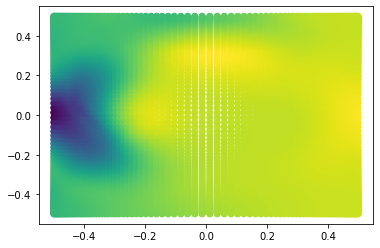

In [57]:
plt.scatter(yy, zz, c=vv)

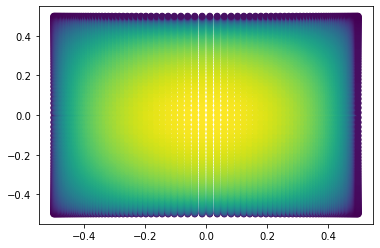

In [23]:
plt.scatter(yy, zz, c=all_data)

In [4]:
all_data.

(9216,)

# Iterative methods

We can see above that a linear regression problem can be solved directly

What happens when we can't invert the matrix?


In [ ]:



class LinearRegressionIterative(BaseRegressor):
    
    
    def zero_grad(self):
        pass
    
    def backward(self, true_values, output_values):
        """
        Numerically calculate the gradient of the loss function wrt the current weights
        """
        pass
    
    def step(self):
        pass
    
    
    
# optimizer.zero_grad()   # zero the gradient buffers
# output = net(input)
# loss = criterion(output, target)
# loss.backward()
# optimizer.step() 

# Improving convergence with alternative optimizers and second-order methods

+ Need a dataset where Linear regression fails
+ Learning rate